In [3]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32

In [4]:
def APPM_RT256():
    RT = []
    for i in range(256):
        row = []
        count = (i*60)%256
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 256:
                count -= 256
        RT.append(row)
    RT = np.array(RT)
    return RT

In [5]:
def APPM_RT64():
    RT = []
    for i in range(256):
        row = []
        count = (i*14)%64
        for j in range(256):
            row.append(count)
            count += 1
            if count >= 64:
                count -= 64
        RT.append(row)
    RT = np.array(RT)
    return RT

In [6]:
class Queue():
    def __init__(self):
        self.q = []
        self.r = -1
    def reset(self):
        self.q = []
        self.r = -1    
    def enqueue(self,r,c):
        self.q.append((r,c))
    def dequeue(self):
        self.r += 1
        if self.r >= len(self.q):
            return False
        return self.q[self.r]

In [7]:
def BFS(RT,r,c,g,tol=None,flag=None):
    Q = Queue()
    Q.enqueue(r,c)
    F = np.full((RT.shape[0],RT.shape[1]),False,dtype=bool)
    F[r,c] = True
    while True:
        k = Q.dequeue()
        if k == False:
            break
        if RT[k[0],k[1]] == g:
            if((k[0] > tol[0] and k[0] < tol[2] and k[1] > tol[1] and k[1] < tol[3]) or (flag)):
                return k
            else:
                flag = True

        if k[0] != 0 and not F[k[0]-1,k[1]]:
            Q.enqueue(k[0]-1,k[1])
            F[k[0]-1,k[1]] = True
        if k[0] != RT.shape[0]-1 and not F[k[0]+1,k[1]]:
            Q.enqueue(k[0]+1,k[1]) 
            F[k[0]+1,k[1]] = True
        if k[1] != 0 and not F[k[0],k[1]-1]:
            Q.enqueue(k[0],k[1]-1)
            F[k[0],k[1]-1] = True
        if k[1] != RT.shape[1]-1 and not F[k[0],k[1]+1]:
            Q.enqueue(k[0],k[1]+1)  
            F[k[0],k[1]+1] = True  



In [8]:
def hashB(npArray,bits):
    return np.mod(xxh32(npArray).intdigest(), 2**bits)

In [9]:
def fold(arr,bit):
    k = B2D.Dec2Bin(arr)
    l = len(k)
    while(l > bit):
        l >>= 1
        a = k[:l]
        b = k[l:]
        k = []
        for i in range(l):
            k.append(a[i]^b[i])
    return B2D.Bin2Dec(k)

In [26]:
def bb_tol(Gray,Gray2,G1,G2):
    base = round(Gray)
    low_tol = Gray - (base - 0.5) + (255 - G1) * 0.587
    up_tol = (base + 0.5) - Gray + (G1) *0.587
    blue_low_tol = int(low_tol/0.114)
    blue_up_tol = int(up_tol/0.114)

    base2 = round(Gray2)
    low_tol = Gray2 - (base2 - 0.5) + (255 - G2) * 0.587
    up_tol = (base2 + 0.5) - Gray2 + (G2) *0.587
    blue2_low_tol = int(low_tol/0.114)
    blue2_up_tol = int(up_tol/0.114)
    
    # print(low_tol,base,Green)

    return np.array([blue_low_tol,blue2_low_tol,blue_up_tol,blue2_up_tol])


In [28]:
def rb_tol(Gray,Green):
    base = round(Gray)
    low_tol = Gray - (base - 0.5) + (255 - Green) * 0.587
    up_tol = (base + 0.5) - Gray + (Green) *0.587
    red_low_tol = int(low_tol/0.299)
    blue_low_tol = int(low_tol/0.114)
    red_up_tol = int(up_tol/0.299)
    blue_up_tol = int(up_tol/0.114)


    # print(low_tol,base,Green)

    return np.array([red_low_tol,blue_low_tol,red_up_tol,blue_up_tol])

In [11]:
def limit(R,B):
    R = R >> 5
    R = R << 5
    UR = R + 31
    LR = R

    B = B >> 5
    B = B << 5
    UB = B + 31
    LB = B

    return np.array([LR,LB,UR,UB])

In [56]:
def AVGI(Graph):
    path = 'image/'+Graph
    I=io.imread(path +r'.tiff')
    Stego = I.copy()
    RT = APPM_RT256()

    p = 0
    MSE = 0
    F = 0
    N = 0

    # print(Stego.shape[0],Stego.shape[1],Stego.shape[2])

    for i in range(Stego.shape[0]):
        for j in range(0,Stego.shape[1],4):
            ac = hashB(np.array([Stego[i,j,0],Stego[i,j+1,0]]),24)
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            Gray2 = I[i,j+1,0]*0.299+I[i,j+1,1]*0.587+I[i,j+1,2]*0.114
            Gray3 = I[i,j+2,0]*0.299+I[i,j+2,1]*0.587+I[i,j+2,2]*0.114
            Gray4 = I[i,j+3,0]*0.299+I[i,j+3,1]*0.587+I[i,j+3,2]*0.114            

            tol = bb_tol(Gray,Gray2,Stego[i,j,1],Stego[i,j+1,1])
            tol[0] = Stego[i,j,2] - tol[0]
            tol[1] = Stego[i,j+1,2] - tol[1]
            tol[2] += Stego[i,j,2]
            tol[3] += Stego[i,j+1,2]
            k = BFS(RT,Stego[i,j,2],Stego[i,j+1,2],ac>>16,tol,False)

            tol_3 = rb_tol(Gray3,Stego[i,j+2,1])
            tol_3[0] = Stego[i,j+2,0] - tol_3[0]
            tol_3[1] = Stego[i,j+2,2] - tol_3[1]
            tol_3[2] += Stego[i,j+2,0]
            tol_3[3] += Stego[i,j+2,2]            
            k2 = BFS(RT,Stego[i,j+2,0],Stego[i,j+2,2],(ac>>8)%2**8,tol_3,False)

            tol_4 = rb_tol(Gray4,Stego[i,j+3,1])
            tol_4[0] = Stego[i,j+3,0] - tol_4[0]
            tol_4[1] = Stego[i,j+3,2] - tol_4[1]
            tol_4[2] += Stego[i,j+3,0]
            tol_4[3] += Stego[i,j+3,2]            
            k3 = BFS(RT,Stego[i,j+3,0],Stego[i,j+3,2],(ac)%2**8,tol_4,False)            

            # print(f"i: {i} j: {j} k:{k}")
            # print(Stego[i,j,2],Stego[i,j+1,2],k)
            print(f"i: {i}, j: {j}")

            Stego[i,j,2] = k[0]
            Stego[i,j+1,2] = k[1]
            g_bar = int(round((Gray - 0.299*I[i,j,0] - 0.114*k[0])/0.587))
            g2_bar = int(round((Gray2 - 0.299*I[i,j+1,0] - 0.114*k[1])/0.587))
            if(g_bar < 0 or g_bar > 255 or g2_bar < 0 or g2_bar > 255):
                p += 2
                num = fold(ac>>16,4)
                Stego[i,j,2] >>= 2
                Stego[i,j,2] <<= 2
                Stego[i,j,2] = Stego[i,j,2]+(num >> 2)

                Stego[i,j+1,2] >>= 2
                Stego[i,j+1,2] <<= 2
                Stego[i,j+1,2] = Stego[i,j+1,2]+(num % 4)                
                # g_bar = int(round((Gray - 0.299*Stego[i,j,0] - 0.114*Stego[i,j,2])/0.587))
                # F.append(g_bar)
                # Stego[i,j,1] = np.clip(g_bar,0,255)
            else:
                Stego[i,j,1] = g_bar
                Stego[i,j+1,1] = g2_bar

            Stego[i,j+2,0] = k2[0]
            Stego[i,j+2,2] = k2[1]
            g3_bar = int(round((Gray3 - 0.299*k2[0] - 0.114*k2[1])/0.587))
            if(g3_bar < 0 or g3_bar > 255):
                p +=1
                Stego[i,j+2,0] = I[i,j+2,0]
                num = fold((ac>>8)%2**8,2)
                Stego[i,j+2,2] >>= 2
                Stego[i,j+2,2] <<= 2
                Stego[i,j+2,2] += num               
            else:
                Stego[i,j+2,1] = g3_bar   

            Stego[i,j+3,0] = k3[0]
            Stego[i,j+3,2] = k3[1]
            g4_bar = int(round((Gray4 - 0.299*k3[0] - 0.114*k3[1])/0.587))
            if(g4_bar < 0 or g4_bar > 255):
                p +=1
                Stego[i,j+3,0] = I[i,j+3,0]
                num = fold((ac)%2**8,2)
                Stego[i,j+3,2] >>= 2
                Stego[i,j+3,2] <<= 2
                Stego[i,j+3,2] += num               
            else:
                Stego[i,j+3,1] = g4_bar       

            delta = int(Stego[i,j,2]) - int(I[i,j,2])
            MSE += delta ** 2
            delta = int(Stego[i,j,1]) - int(I[i,j,1])
            MSE += delta ** 2   

            delta = int(Stego[i,j+1,2]) - int(I[i,j+1,2])
            MSE += delta ** 2
            delta = int(Stego[i,j+1,1]) - int(I[i,j+1,1])
            MSE += delta ** 2         

            delta = int(Stego[i,j+2,2]) - int(I[i,j+2,2])
            MSE += delta ** 2
            delta = int(Stego[i,j+2,1]) - int(I[i,j+2,1])
            MSE += delta ** 2
            delta = int(Stego[i,j+2,0]) - int(I[i,j+2,0])
            MSE += delta ** 2                    

            delta = int(Stego[i,j+3,2]) - int(I[i,j+3,2])
            MSE += delta ** 2
            delta = int(Stego[i,j+3,1]) - int(I[i,j+3,1])
            MSE += delta ** 2
            delta = int(Stego[i,j+3,0]) - int(I[i,j+3,0])
            MSE += delta ** 2                     

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)




    # ANS = []
    # for i in range(Stego.shape[0]):
    #     for j in range(0,Stego.shape[1],2):
    #         ANS.append(RT[Stego[i,j],Stego[i,j+1]])

    # if np.all(ANS == msg):
    #     print(ANS[100],msg[100])
    # else:
    #     print("F")

In [61]:
def Authorize(Graph):
    path = "processing_image/"+Graph+".png"
    I=io.imread(path)
    Stego = I.copy()
    RT = APPM_RT256()

    Flag = False

    for i in range(Stego.shape[0]):
        if(Flag):
            break
        for j in range(0,Stego.shape[1],4):
            ac = hashB(np.array([Stego[i,j,0],Stego[i,j+1,0]]),24)
    
            if((ac>>16) != RT[Stego[i,j,2],Stego[i,j+1,2]]):
                num = fold((ac>>16),4)
                num2 = (Stego[i,j,2] % 4)*4+(Stego[i,j+1,2] % 4)
                if(num != num2):
                    print(f"This picture is tampered. i: {i} ,j: {j} ,ac: {(ac>>16)} ,RT: {RT[Stego[i,j,2],Stego[i,j+1,2]]}")
                    Flag = True
                    break
            if(((ac>>8)%2**8) != RT[Stego[i,j+2,0],Stego[i,j+2,2]]):
                num = fold(((ac>>8)%2**8),2)
                num2 = (Stego[i,j+2,2] % 4)
                if(num != num2):
                    print(f"This picture is tampered. i: {i} ,j: {j+2} ,ac: {((ac>>8)%2**8)} ,RT: {RT[Stego[i,j+2,2],Stego[i,j+2,2]]}")
                    Flag = True
                    break  
            if((ac % 2**8) != RT[Stego[i,j+3,0],Stego[i,j+3,2]]):
                num = fold((ac % 2**8),2)
                num2 = (Stego[i,j+3,2] % 4)
                if(num != num2):
                    print(f"This picture is tampered. i: {i} ,j: {j+3} ,ac: {(ac % 2**8)} ,RT: {RT[Stego[i,j+3,2],Stego[i,j+3,2]]}")
                    Flag = True
                    break   

    if(not Flag):
        print("This picture is not tampered.")

              

i: 0, j: 0
i: 0, j: 4
i: 0, j: 8
i: 0, j: 12
i: 0, j: 16
i: 0, j: 20
i: 0, j: 24
i: 0, j: 28
i: 0, j: 32
i: 0, j: 36
i: 0, j: 40
i: 0, j: 44
i: 0, j: 48
i: 0, j: 52
i: 0, j: 56
i: 0, j: 60
i: 0, j: 64
i: 0, j: 68
i: 0, j: 72
i: 0, j: 76
i: 0, j: 80
i: 0, j: 84
i: 0, j: 88
i: 0, j: 92
i: 0, j: 96
i: 0, j: 100
i: 0, j: 104
i: 0, j: 108
i: 0, j: 112
i: 0, j: 116
i: 0, j: 120
i: 0, j: 124
i: 0, j: 128
i: 0, j: 132
i: 0, j: 136
i: 0, j: 140
i: 0, j: 144
i: 0, j: 148
i: 0, j: 152
i: 0, j: 156
i: 0, j: 160
i: 0, j: 164
i: 0, j: 168
i: 0, j: 172
i: 0, j: 176
i: 0, j: 180
i: 0, j: 184
i: 0, j: 188
i: 0, j: 192
i: 0, j: 196
i: 0, j: 200
i: 0, j: 204
i: 0, j: 208
i: 0, j: 212
i: 0, j: 216
i: 0, j: 220
i: 0, j: 224
i: 0, j: 228
i: 0, j: 232
i: 0, j: 236
i: 0, j: 240
i: 0, j: 244
i: 0, j: 248
i: 0, j: 252
i: 0, j: 256
i: 0, j: 260
i: 0, j: 264
i: 0, j: 268
i: 0, j: 272
i: 0, j: 276
i: 0, j: 280
i: 0, j: 284
i: 0, j: 288
i: 0, j: 292
i: 0, j: 296
i: 0, j: 300
i: 0, j: 304
i: 0, j: 308
i: 0, j: 312
i

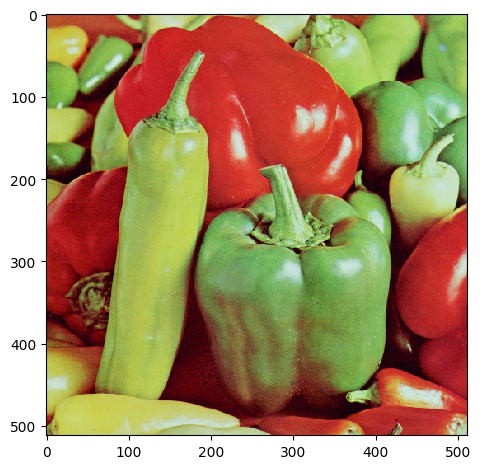

In [58]:
AVGI('Peppers')

In [62]:
Authorize('Peppers')

This picture is not tampered.


In [16]:
# path = 'image/'+'Tiffany'
# I=io.imread(path +r'.tiff')
# ac = hashB(np.array([I[0,1,0]//2**3,I[0,1,2]//2**3]),6)
# kk = limit(I[0,1,0],I[0,1,2])
# print(kk)
# print(I[0,1,0],I[0,1,1],I[0,1,2],I[0,1,0]//2**3,I[0,1,2]//2**3,ac)

# path = "processing_image/"+'Tiffany'+".png"
# I=io.imread(path)
# ac = hashB(np.array([I[0,1,0]//2**4,I[0,1,2]//2**4]),6)
# print(I[0,1,0],I[0,1,1],I[0,1,2],I[0,1,0]//2**3,I[0,1,2]//2**3,ac)

[160 128 191 159]
180 183 157 22 19 56
180 181 166 22 20 39
